<a href="https://colab.research.google.com/github/AmirMAAI/Titanic/blob/main/titanic_dataset_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="1"></a> <br>
# 1. Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import plot_confusion_matrix,classification_report,confusion_matrix,accuracy_score

<a id="1"></a> <br>
# 2. Import Dataset

In [2]:
# Import Train Dataset
df_train = pd.read_csv('/content/titanic_train.csv')

# Import Test Dataset
df_test = pd.read_csv('/content/titanic_test.csv')

# Concat Two Datasets
df_data = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)

In [3]:
df_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


<a id="1"></a> <br>
# 2. Missing Values

In [4]:
# Obtain Columns with missing_values
missing_values = [col for col in df_data.columns if df_data[col].isnull().any()]
df_data[missing_values].isnull().sum()

Age          263
Cabin       1014
Embarked       2
Fare           1
Survived     418
dtype: int64

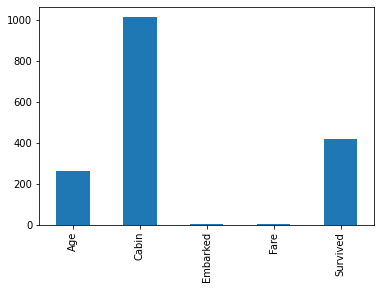

In [5]:
df_data[missing_values].isnull().sum().plot(kind = 'bar')

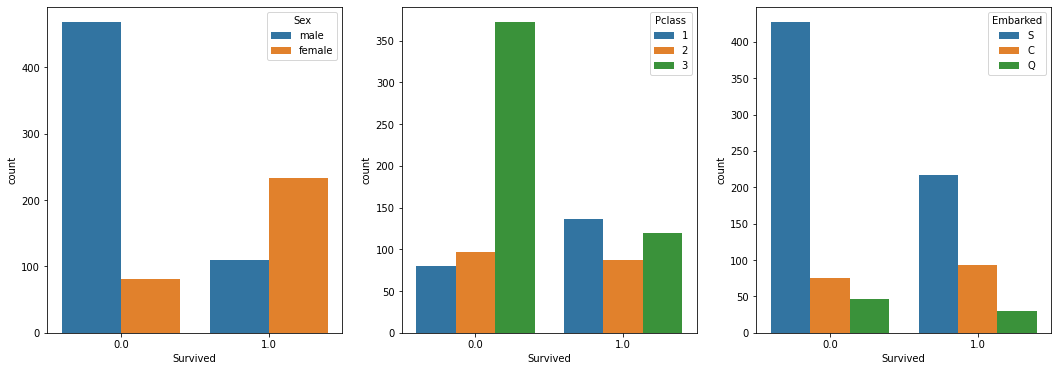

In [6]:
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(18,6))
sns.countplot(x ='Survived',hue='Sex', data=df_data,ax=axes[0])
sns.countplot(x ='Survived',hue='Pclass', data=df_data,ax=axes[1])
sns.countplot(x ='Survived',hue='Embarked', data=df_data,ax=axes[2])

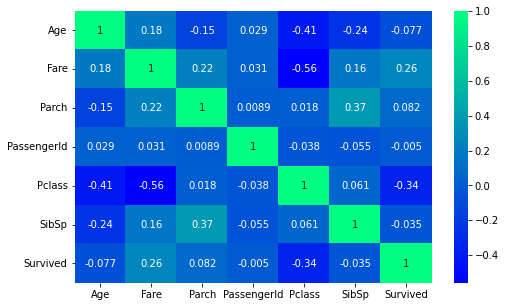

In [7]:
#Corralation
plt.figure(figsize=(8,5))
sns.heatmap(df_data.corr(),annot=True,cmap='winter')
plt.show()

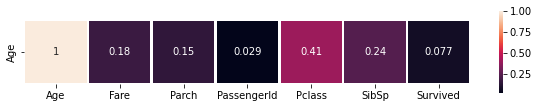

In [8]:
df_Age_corr = pd.DataFrame(df_data.corr()['Age'].abs()) 
f, ax = plt.subplots(figsize=(10,1.5),facecolor='white')
sns.heatmap(df_Age_corr.transpose(),annot=True,square=True,linewidth=1.5,cmap='rocket')

<span style="font-family:cursive; color:black;font-size:16px"> Since PClass is the variable that is most correlated with both Age and Survived, we will group passengers according to the class they belong to. What we will do is replace the missing values with the median of each group.</span>

In [9]:
df_data.Age = df_data.groupby(['Pclass','Sex'])['Age'].apply(lambda x: x.fillna(x.median()))
print('Number of Missing Value for Age is : {}'.format(df_data.Age.isnull().sum()))

Number of Missing Value for Age is : 0


<span style="font-family:cursive; color:black;font-size:16px">For Embarked, we will replace the missing values by the mode, i.e. the most repeated value.</span>

In [10]:
df_data.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [11]:
mode = 'S'
df_data.Embarked.replace(np.nan, mode, inplace=True)
print('Number of Missing Value for Embarked is : {}'.format(df_data.Embarked.isnull().sum()))

Number of Missing Value for Embarked is : 0


<span style="font-family:cursive; color:black;font-size:16px">We have one missing value for Fare, belonging to one male of the testing dataset. We can assume that it is related to FamilySize and PClass. Median Fare value of a male with a third class ticket and no family is a logical choice to fill the missing value.</span>

In [12]:
df_data[df_data.Fare.isnull()==True]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [13]:
median_Fare = df_data.groupby(['Pclass','Parch','SibSp']).Fare.median()[3][0][0]
df_data.Fare = df_data.Fare.fillna(median_Fare)
print('Number of Missing Value for Fare is : {}'.format(df_data.Fare.isnull().sum()))

Number of Missing Value for Fare is : 0


In [14]:
# Remove Cabin Columns
df_data.drop('Cabin', axis=1, inplace=True)

<span style="font-family:cursive; color:black;font-size:16px">Now, we don't have any Missing Data except Survived that belonging to test Data.</span>

In [15]:
df_data.isnull().sum()

Age              0
Embarked         0
Fare             0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
dtype: int64

<a id="1"></a> <br>
# 3. Feature Engineering

<span style="font-family:cursive; color:black;font-size:16px">We will start by creating fields related to the family unit. The first of these will come from the SibSp and Parch fields, which we can remove later. This will reflect the size of passengers' family. We will also enter a field to indicate whether the passenger is travelling alone or not.</span>

In [16]:
df_data['FamilySize'] = df_data['Parch'] + df_data['SibSp'] + 1
df_data['Alone'] = 0
df_data['Alone'] = df_data['FamilySize'].apply(lambda x: 0 if x>1 else 1)
df_data.drop(['Parch','SibSp'],axis=1, inplace=True)

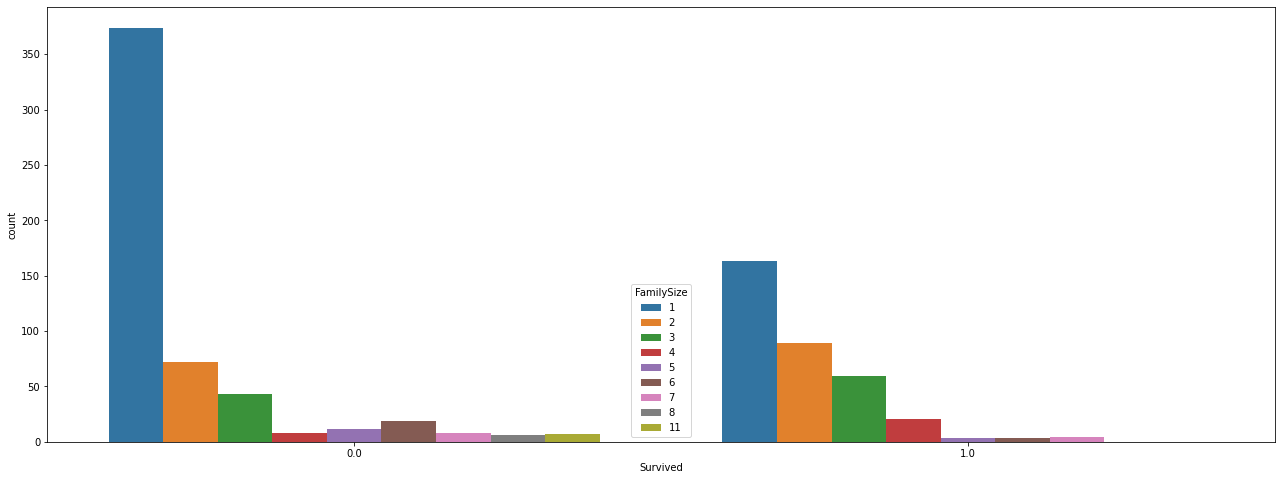

In [17]:
fig, axes = plt.subplots(figsize=(22,8))
sns.countplot(x ='Survived',hue='FamilySize', data=df_data)

<span style="font-family:cursive; color:black;font-size:16px">I have decided to group Family Size into 4 different groups:</span>

    Alone: for people travelling with no member of his/her family.
    Small: for people travelling with 3 members of family
    Medium: travelling with 4 or 5 members of family
    Large: travelling with 6+ members of family

In [18]:
family_group = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_data['FamilyGroup'] = df_data['FamilySize'].map(family_group)

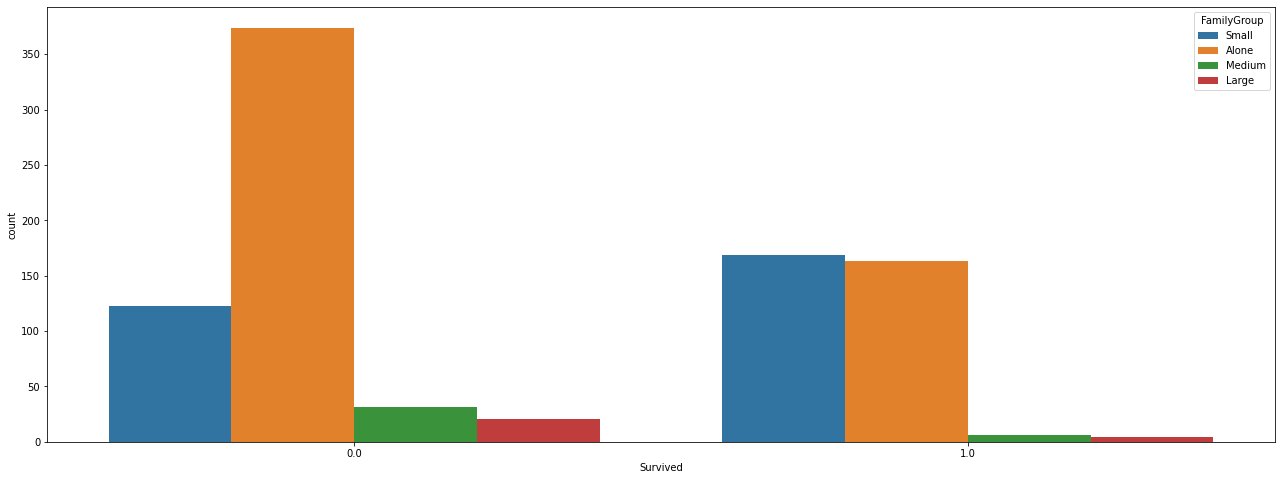

In [19]:
fig, axes = plt.subplots(figsize=(22,8))
sns.countplot(x ='Survived',hue='FamilyGroup', data=df_data)

<span style="font-family:cursive; color:black;font-size:16px">Based on the chart above ,we can observe that lonely people tend to die. On the other hand, small families members are most likely to survive.</span>

<span style="font-family:cursive; color:black;font-size:16px">Now we are going to add a column that will be related to the Name field:</span>

In [20]:
df_data['Title'] = df_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(df_data['Title'], df_data['Sex']).transpose()


Title,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1


In [21]:
df_data['Title'] = df_data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df_data['Title'] = df_data['Title'].replace('Mlle', 'Miss')
df_data['Title'] = df_data['Title'].replace('Ms', 'Miss')
df_data['Title'] = df_data['Title'].replace('Mme', 'Mrs')
pd.crosstab(df_data['Title'], df_data['Sex']).transpose()

Title,Master,Miss,Mr,Mrs,Rare
Sex,,,,,
female,0,264,0,198,4
male,61,0,757,0,25


<span style="font-family:cursive; color:black;font-size:16px">In order to binning continuous features we are going to use 13 quantile base bins for Fare column and 10 bins for Age column:</span>

In [22]:
names = ['1', '2', '3', '4', '5', '6', '7','8','9','10','11','12','13']
df_data['Fare'] = pd.qcut(df_data['Fare'], 13, labels = names)
df_data.Fare = pd.to_numeric(df_data.Fare, errors = 'coerce')

In [23]:
names = ['1','2','3','4','5','6','7','8','9','10']
df_data['Age'] = pd.qcut(df_data['Age'], 10, labels = names)

<span style="font-family:cursive; color:black;font-size:16px">Remove Name,PassengerId and Ticket columns:</span>

In [24]:
Remove_List = ['Name','PassengerId','Ticket']
df_data.drop(Remove_List, axis=1, inplace=True)

<a id="1"></a> <br>
# 4. Feature Transformation

<span style="font-family:cursive; color:black;font-size:16px">Using LabelEncoder, we are going to convert non-numerical features to numerical type. LabelEncoder basically labels the classes from 0 to n. This process is necessary for models to learn from those features.</span>

In [25]:
n_col = [col for col in df_data.columns if df_data[col].dtype=='object']
n_col.append('Age')
for feature in n_col:
    df_data[feature] = LabelEncoder().fit_transform(df_data[feature])

In [26]:
df_data.head()

,Age,Embarked,Fare,Pclass,Sex,Survived,FamilySize,Alone,FamilyGroup,Title
0,3,2,1,3,1,0.0,2,0,3,2
1,8,0,12,1,0,1.0,2,0,3,3
2,5,2,4,3,0,1.0,1,1,0,1
3,8,2,11,1,0,1.0,2,0,3,3
4,8,2,4,3,1,0.0,1,1,0,2


In [27]:
df_data.dtypes

Age              int64
Embarked         int64
Fare             int64
Pclass           int64
Sex              int64
Survived       float64
FamilySize       int64
Alone            int64
FamilyGroup      int64
Title            int64
dtype: object

<span style="font-family:cursive; color:black;font-size:16px">To finish with, we are going to one hot encoded non-ordinal features. Those features are Embarked, Title, FamilyGroup and PClass. Age and Fare as ordinal features are not converted.</span>

In [28]:
cat_features = ['Embarked', 'Pclass', 'Title', 'FamilyGroup']
for feature in cat_features:
    one_hot = pd.get_dummies(df_data[feature],prefix=feature)
    df_data = pd.merge(left=df_data,right=one_hot,left_index=True,right_index=True)

In [29]:
df_data.drop(columns=['Embarked','Pclass','Title','FamilyGroup'],inplace=True)

In [30]:
df_data.head()

,Age,Fare,Sex,Survived,FamilySize,Alone,Embarked_0,Embarked_1,Embarked_2,Pclass_1,...,Pclass_3,Title_0,Title_1,Title_2,Title_3,Title_4,FamilyGroup_0,FamilyGroup_1,FamilyGroup_2,FamilyGroup_3
0,3,1,1,0.0,2,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
1,8,12,0,1.0,2,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,5,4,0,1.0,1,1,0,0,1,0,...,1,0,1,0,0,0,1,0,0,0
3,8,11,0,1.0,2,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,1
4,8,4,1,0.0,1,1,0,0,1,0,...,1,0,0,1,0,0,1,0,0,0


<a id="1"></a> <br>
# 5. Modeling

<span style="font-family:cursive; color:black;font-size:16px">For the modeling part we will compare 7 known algorithms, and proceed to evaluate their average accuracy by a stratified kfold cross validation procedure:</span>

1: SVC<br>
2: Decision Tree<br>
3: Random Forest<br>
4: Extra Trees<br>
5: Gradient Boosting<br>
6: Multiple layer perceprton (neural network)<br>
7: KNN<br>

In [31]:
# ٍExtract Train and Test Data from df_data
df_train = df_data[df_data.Survived.isnull()==False]
df_test = df_data[df_data.Survived.isnull()==True]
df_test= df_test.drop('Survived',axis=1)

In [32]:
X = df_train.drop('Survived',axis=1)
y = df_train['Survived']

In [33]:
# Define classifiers:
kfold = StratifiedKFold(n_splits=10)
random_state = 42
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(max_depth=4,random_state=random_state))
classifiers.append(RandomForestClassifier(n_estimators=5,random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())

In [34]:
# cross_val_score
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X, y, scoring = "accuracy", cv = kfold, n_jobs=4))

In [35]:
# cross_val_score Mean
cv_means = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())

In [36]:
# Create DataFram from Algorithms and CrossValMeans parameter
cv_res = pd.DataFrame({"Algorithm":["SVC","DecisionTree",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors"],"CrossValMeans":cv_means})
cv_res = cv_res.sort_values(by='CrossValMeans',ascending = False)

In [37]:
cv_res

,Algorithm,CrossValMeans
0,SVC,0.829401
5,MultipleLayerPerceptron,0.822709
4,GradientBoosting,0.821623
1,DecisionTree,0.806941
6,KNeighboors,0.796941
3,ExtraTrees,0.794644
2,RandomForest,0.787878


In [38]:
# SPlitting train dataset
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [39]:
# Classifiers
pipeline_SVC = Pipeline([('SVC_classifier',SVC(random_state=random_state))])
pipeline_DTC = Pipeline([('DTC_classifier',DecisionTreeClassifier(max_depth=4,random_state=random_state))])
pipeline_RF = Pipeline([('RF_classifier',RandomForestClassifier(n_estimators=5,random_state=random_state))])
pipeline_ET = Pipeline([('ET_classifier',ExtraTreesClassifier(random_state=random_state))])
pipeline_GB = Pipeline([('GB_classifier',GradientBoostingClassifier(random_state=random_state))])
pipeline_MLP = Pipeline([('MLP_classifier',MLPClassifier(max_iter=10000,random_state=random_state))])
pipeline_KNN = Pipeline([('KNN_classifier',KNeighborsClassifier())])

pipelines = [pipeline_SVC,pipeline_DTC,pipeline_RF,pipeline_ET,pipeline_GB,pipeline_MLP,pipeline_KNN]
pipe_dict = {0:'SVC',1:'DecisionTree',2:'RandomForest',3:'ExtraTrees',4:'GradientBoosting',
             5:'MLP',6:'KNeighbors'}

In [40]:
# Fit Model
for pipe in pipelines:
    pipe.fit(X_train,y_train)

In [41]:
# Calculate Test Accuracy
for i,model in enumerate(pipelines):
    print("{} Test Accuracy : {}\n".format(pipe_dict[i],model.score(X_test,y_test)))

SVC Test Accuracy : 0.8268156424581006

DecisionTree Test Accuracy : 0.8156424581005587

RandomForest Test Accuracy : 0.7988826815642458

ExtraTrees Test Accuracy : 0.8156424581005587

GradientBoosting Test Accuracy : 0.8435754189944135

MLP Test Accuracy : 0.8324022346368715

KNeighbors Test Accuracy : 0.8044692737430168



In [42]:
# Calculate mean_absolute_error
for i,model in enumerate(pipelines):
    y_pred = model.predict(X_test)
    print("{} : mean_absolute_error : {}\n".format(pipe_dict[i],mean_absolute_error(y_test,y_pred)))

SVC : mean_absolute_error : 0.17318435754189945

DecisionTree : mean_absolute_error : 0.18435754189944134

RandomForest : mean_absolute_error : 0.2011173184357542

ExtraTrees : mean_absolute_error : 0.18435754189944134

GradientBoosting : mean_absolute_error : 0.1564245810055866

MLP : mean_absolute_error : 0.16759776536312848

KNeighbors : mean_absolute_error : 0.19553072625698323



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


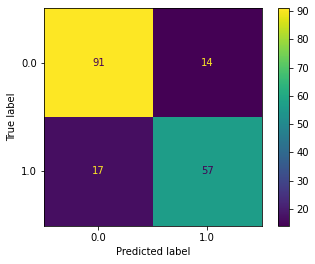

In [43]:
plot_confusion_matrix(pipeline_SVC,X_test,y_test)

In [44]:
y_pred_test_SVC = pipeline_SVC.predict(df_test)

In [45]:
y_pred_test_SVC

array([0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1.

In [46]:
df_gender_submission = pd.read_csv('/content/titanic_gender_submission.csv')

In [47]:
# Sample Submission
output = pd.DataFrame({'PassengerId': df_gender_submission.PassengerId, 'Survived': y_pred_test_SVC})

output.to_csv("/content/submission.csv", index = False)
